# Soft Actor-Critic for Model-free Learning-based Control


In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_probability as tfp
from tensorflow.keras.layers import Dense 
from tensorflow.keras.optimizers import Adam
import gym
import matplotlib.pyplot as plt
from IPython.display import Video, display
import cv2

In [2]:
print("TensorFlow %s" % tf.__version__)
print("tfp %s" % tfp.__version__)
print("Keras %s" % keras.__version__)
print("gym %s" % gym.__version__)
print("numpy %s" % np.__version__)

TensorFlow 2.10.0
tfp 0.18.0
Keras 2.10.0
gym 0.26.2
numpy 1.23.0


## SAC algorithm

**Quick Facts**
* SAC is an off-policy algorithm and the policy is stochastic.
* SAC uses the actor-critic architecture, where the actor represents the policy network for selecting the action, while the critic represents the value network for evaluating the action.
* The version of SAC implemented here can only be used for environments with continuous action spaces. An alternate version of SAC, which slightly changes the policy update rule, can be implemented to handle discrete action spaces.
* A central feature of SAC is entropy regularization. The policy is trained to maximize a trade-off between expected return and entropy, a measure of randomness in the policy. This has a close connection to the exploration-exploitation trade-off: increasing entropy results in more exploration, which can accelerate learning later on. It can also prevent the policy from prematurely converging to a bad local optimum.

**Entropy-Regularized Reinforcement Learning**
$$H(P) = \underset{x \sim P}{{\mathbb{E}}}\left[-\log P(x)\right]$$
$$
\pi^* = \arg \max_{\pi} \underset{\tau \sim \pi}{{\mathbb{E}}} \left[\sum_{t=0}^{\infty} \gamma^t\left(R(s_t,a_t, s_{t+1})+\alpha H\left(\pi(\cdot|s_t)\right)\right)\right]
$$
where $\alpha>0$ is the trade-off (temperature) coefficient.
$$
V^{\pi}(s) =  \underset{\tau \sim \pi}{{\mathbb{E}}} \left[\sum_{t=0}^{\infty} \gamma^t\left(R(s_t,a_t, s_{t+1})+\alpha H\left(\pi(\cdot|s_t)\right)\right)\bigg| s_0=s\right]
$$
$$
Q^{\pi}(s,a) =  \underset{\tau \sim \pi}{{\mathbb{E}}} \left[\sum_{t=0}^{\infty} \gamma^t R(s_t,a_t, s_{t+1})+\alpha \sum_{t=1}^{\infty} \gamma^t H\left(\pi(\cdot|s_t)\right)\bigg| s_0=s, a_0=a\right]
$$
$$
V^{\pi}(s) = \underset{a \sim \pi}{{\mathbb{E}}} \left[Q^{\pi}(s,a)\right] + \alpha H\left(\pi(\cdot|s)\right)  =  \underset{a \sim \pi}{{\mathbb{E}}} \left[Q^{\pi}(s,a)\right] - \alpha \log \pi(\cdot|s)
$$
The Bellman equation for $Q^{\pi}$ is
$$
\begin{align}
Q^{\pi}(s,a) &=  \underset{\substack{s' \sim P \\ a' \sim \pi}}{\mathbb{E}} \left[R(s,a,s') + \gamma \left(Q^{\pi}(s',a')+\alpha H\left(\pi(\cdot|s')\right)\right) \right] \\
&=  \underset{s' \sim P}{{\mathbb{E}}}\left[R(s,a,s') + \gamma V^{\pi}(s') \right]
\end{align}
$$
The advantage function $A^{\pi}(s,a)$ corresponding to a policy $\pi$ describes how much better it is to take a specific action $a$ in state $s$, over randomly selecting an action according to $\pi(\cdot|s)$, assuming you act according to $\pi$ forever after. Mathematically, the advantage function is defined by
$$
A^{\pi}(s,a) = Q^{\pi}(s,a) - V^{\pi}(s)
$$

**SAC Algorithm**

SAC concurrently learns a policy $\pi_{\phi}$, two Q-functions $Q_{\theta_1}$, $Q_{\theta_2}$, a network for the value function $V_{\psi}$ and another for target value function $V_{\bar{\psi}}$. There are two variants of SAC that are currently standard: one that uses a fixed entropy regularization coefficient $\alpha$, and another that enforces an entropy constraint by varying $\alpha$ over the course of training. For simplicity, we make use of the version with a fixed entropy regularization coefficient, but the entropy-constrained variant is generally preferred by practitioners. 



The loss functions for the value network in SAC are:

$$L_V(\psi, {\mathcal D}) = \underset{(s,a,r,s',d_t) \sim {\mathcal D}}{{\mathbb{E}}}\left[
   \frac{1}{2}(V_{\psi}(s) - y_v(s))^2\right]$$

where the target is given by
$$y_v(s) = \underset{a \sim \pi_{\phi}}{{\mathbb{E}}} \left[\min_{j=1,2} Q_{\theta_{\text{targ},j}}(s, a) - \alpha \log \pi_{\phi}(a|s) \right]$$

The loss functions for the Q-networks in SAC are:

$$L_Q(\theta_i, {\mathcal D}) = \underset{(s,a,r,s',d_t) \sim {\mathcal D}}{{\mathbb{E}}}\left[
   \frac{1}{2}( Q_{\theta_i}(s,a) - y(r,s',d_t))^2\right]$$

where the target is given by
$$y(r, s', d_t) = r + \gamma (1 - d_t) \underset{s' \sim P}{{\mathbb{E}}} \left[V_{\bar{\psi}}(s')\right]$$

It should be noted that later versions of SAC removed the explicit value network (V) and instead used the target Q-network directly for bootstrapping function:

$$y(r, s', d_t) = r + \gamma (1 - d_t) \left( \min_{j=1,2} Q_{\theta_{\text{targ},j}}(s', \tilde{a}') - \alpha \log \pi_{\phi}(\tilde{a}'|s') \right), \quad \tilde{a}' \sim \pi_{\phi}(\cdot|s')$$

For the actor network the loss function can be formulated as
$$L_{\pi}(\phi) = \underset{\substack{s \sim {\mathcal D} \\ \xi \sim \mathcal{N}}}{\mathbb{E}} \left[\alpha \log \pi_{\phi}(\tilde{a}_{\phi}(s,\xi)|s) - \min_{j=1,2} Q_{\theta_j}(s,\tilde{a}_{\phi}(s,\xi)) \right]$$
where using the reparameterization trick, in which a sample from $\pi_{\phi}(\cdot|s)$ is drawn by computing a deterministic function of state, policy parameters, and independent noise. Thus, the samples are obtained according to

$$
\tilde{a}_{\phi}(s, \xi) = \tanh\left( \mu_{\phi}(s) + \sigma_{\phi}(s) \odot \xi \right), \;\;\;\;\; \xi \sim \mathcal{N}(0, I).
$$
The update of network parameters is as follows, and the training process of SAC is summarized below, mwhere $E$ denotes the number of algorithm training (episodes), $K$ denotes the number of network training and $t$ denotes the $t^{th}$ interaction between agent and environment. Also $d_t$ is the index for "done" that if $d_t=1$ the interaction ends. 



In [3]:
class ReplayBuffer:
    def __init__(self, max_size, state_dim, action_dim):
        self.max_size = max_size
        self.ptr = 0
        self.size = 0
        
        # For a 4-DOF suspension system (state_dim=8, action_dim=1)
        self.states = np.zeros((max_size, state_dim))
        self.actions = np.zeros((max_size, action_dim))
        self.rewards = np.zeros((max_size, 1))
        self.next_states = np.zeros((max_size, state_dim))
        self.dones = np.zeros((max_size, 1))

    def store(self, state, action, reward, next_state, done):
        # Store experiences with dimensions suitable for the suspension system
        self.states[self.ptr] = state
        self.actions[self.ptr] = action
        self.rewards[self.ptr] = reward
        self.next_states[self.ptr] = next_state
        self.dones[self.ptr] = done
        
        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

    def sample(self, batch_size):
        # Random sampling for SAC
        idx = np.random.randint(0, self.size, size=batch_size)
        
        return (
            self.states[idx],
            self.actions[idx],
            self.rewards[idx],
            self.next_states[idx],
            self.dones[idx]
        )

    def __len__(self):
        return self.size


In [4]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense
import tensorflow as tf

class CriticNetwork(Model):
    def __init__(self, name='critic'):
        super(CriticNetwork, self).__init__(name=name)
        self.fc1_q1 = Dense(1024, activation='swish')
        self.fc2_q1 = Dense(512, activation='swish')
        self.q1 = Dense(1, activation=None)  # Output shape: (batch_size, 1)

        self.fc1_q2 = Dense(256, activation='relu')
        self.fc2_q2 = Dense(256, activation='relu')
        self.q2 = Dense(1, activation=None)  # Output shape: (batch_size, 1)

    def call(self, state, action):
        state_action = tf.concat([state, action], axis=1)
        
        # Q1 network
        x1 = self.fc1_q1(state_action)
        x1 = self.fc2_q1(x1)
        q1 = self.q1(x1)  # Shape: (batch_size, 1)

        # Q2 network
        x2 = self.fc1_q2(state_action)
        x2 = self.fc2_q2(x2)
        q2 = self.q2(x2)  # Shape: (batch_size, 1)

        return q1, q2


In [5]:
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras import Model

class ValueNetwork(Model):
    def __init__(self, 
                 fc1_dims=512,  # Increased capacity for nonlinear dynamics
                 fc2_dims=256, 
                 use_batchnorm=True,  # Optional: for training stability
                 use_dropout=False,   # Optional: to prevent overfitting
                 name='value'):
        super(ValueNetwork, self).__init__(name=name)
        
        self.fc1 = Dense(fc1_dims, activation='relu')
        self.fc2 = Dense(fc2_dims, activation='relu')
        self.v = Dense(1, activation=None)
        
        # Optional layers
        self.use_batchnorm = use_batchnorm
        self.use_dropout = use_dropout
        if self.use_batchnorm:
            self.bn1 = BatchNormalization()
            self.bn2 = BatchNormalization()
        if self.use_dropout:
            self.do1 = Dropout(0.1)
            self.do2 = Dropout(0.1)

    def call(self, state, training=False):
        # Processing the input state (8-dimensional)
        x = self.fc1(state)
        
        if self.use_batchnorm:
            x = self.bn1(x, training=training)
        if self.use_dropout:
            x = self.do1(x, training=training)
        
        x = self.fc2(x)
        
        if self.use_batchnorm:
            x = self.bn2(x, training=training)
        if self.use_dropout:
            x = self.do2(x, training=training)
        
        v = self.v(x)
        return v


In [6]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras import Model
import tensorflow_probability as tfp

class ActorNetwork(Model):
    def __init__(self, 
                 max_action=1000,  # Control force range ±1000N
                 fc1_dims=512, 
                 fc2_dims=512, 
                 name='actor'):
        super(ActorNetwork, self).__init__(name=name)
        
        self.fc1 = Dense(fc1_dims, activation='relu')
        self.fc2 = Dense(fc2_dims, activation='relu')
        self.mu = Dense(1, activation=None)       # One-dimensional output
        self.sigma = Dense(1, activation=None)    # One-dimensional output
        
        self.max_action = max_action
        self.noise = 1e-6  # Minimum noise for numerical stability

    def call(self, state):
        x = self.fc1(state)
        x = self.fc2(x)
        
        mu = self.mu(x)
        sigma = self.sigma(x)
        
        # Clip sigma to control noise
        sigma = tf.clip_by_value(sigma, -20, 2)  # Clamp before applying exp
        sigma = tf.exp(sigma) + self.noise       # Ensure positive value
        
        return mu, sigma

    def sample_normal(self, state, reparameterize=True):
        mu, sigma = self.call(state)
        
        if reparameterize:
            # Reparameterization trick for training
            epsilon = tf.random.normal(shape=mu.shape)
            actions = mu + epsilon * sigma
        else:
            # Direct sampling for inference
            dist = tfp.distributions.Normal(mu, sigma)
            actions = dist.sample()
        
        # Apply tanh to limit the action range
        action = tf.tanh(actions) * self.max_action
        
        # Compute log probability with tanh correction
        log_probs = tfp.distributions.Normal(mu, sigma).log_prob(actions)
        log_probs -= tf.math.log(1 - tf.tanh(actions)**2 + self.noise)
        log_probs = tf.reduce_sum(log_probs, axis=1, keepdims=True)
        
        return action, log_probs


In [7]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam

class Agent:
    def __init__(self, 
                 alpha=3e-4, 
                 beta=3e-4, 
                 input_dims=[8],  # 8-dimensional state for suspension system
                 env=None, 
                 gamma=0.99, 
                 n_actions=1,     # 1-dimensional action
                 max_size=1_000_000, 
                 tau=0.005,
                 layer1_size=256, 
                 layer2_size=256, 
                 batch_size=256, 
                 reward_scale=2, max_action=1):
        
        self.gamma = gamma
        self.tau = tau
        self.memory = ReplayBuffer(max_size = 2_000_000, state_dim=input_dims[0], action_dim=n_actions)
        self.batch_size = batch_size
        self.n_actions = n_actions

        # Entropy temperature setup
        self.log_alpha = tf.Variable(0.0, dtype=tf.float32, trainable=True)
        self.target_entropy = -tf.cast(n_actions, tf.float32) * 0.8
        self.alpha_optimizer = Adam(learning_rate=beta)

        # Neural networks
        self.actor = ActorNetwork(max_action=env.action_space.high[0], name='actor')
        self.critic_1 = CriticNetwork(name='critic_1')
        self.critic_2 = CriticNetwork(name='critic_2')
        self.value = ValueNetwork(name='value')
        self.target_value = ValueNetwork(name='target_value')

        # Optimizers
        self.actor_optimizer = Adam(learning_rate=alpha)
        self.critic_1_optimizer = Adam(learning_rate=beta)
        self.critic_2_optimizer = Adam(learning_rate=beta)
        self.value_optimizer = Adam(learning_rate=beta)
        self.alpha_optimizer = Adam(learning_rate=beta)

        self.scale = reward_scale
        self.update_network_parameters(tau=1)

        # History trackers
        self.actor_losses = []
        self.critic_losses = []
        self.value_losses = []
        self.alpha_losses = []
        self.value_loss_history = []    # For scalar values only
        self.critic_loss_history = []   # For scalar values only
        self.actor_probs_history = []   # For scalar values only
        self.alpha_history = []
        self.critic_1_loss_history = []
        self.critic_2_loss_history = []

    @property
    def alpha(self):
        return tf.exp(self.log_alpha)

    def choose_action(self, observation, deterministic=False):
        state = tf.convert_to_tensor([observation], dtype=tf.float32)
        
        if deterministic:
            mu, _ = self.actor(state)
            action = tf.tanh(mu) * self.actor.max_action
        else:
            action, _ = self.actor.sample_normal(state)
            
        if np.random.rand() < 0.3:  # 30% chance of noise
            action += np.random.normal(0, 0.2, size=action.shape)
        
        return action.numpy()[0]

    def remember(self, state, action, reward, new_state, done):
        self.memory.store(state, action, reward, new_state, done)

    def update_network_parameters(self, tau=None):
        tau = tau or self.tau
        # Update target value network
        for target, source in zip(self.target_value.weights, self.value.weights):
            target.assign(tau * source + (1 - tau) * target)

    def learn(self):
        if self.memory.size < self.batch_size:
            return

        states, actions, rewards, states_, dones = self.memory.sample(self.batch_size)
        
        states = tf.convert_to_tensor(states, dtype=tf.float32)
        actions = tf.convert_to_tensor(actions, dtype=tf.float32)
        rewards = tf.convert_to_tensor(rewards, dtype=tf.float32)
        states_ = tf.convert_to_tensor(states_, dtype=tf.float32)
        dones = tf.convert_to_tensor(dones, dtype=tf.float32)

        # Update value network
        with tf.GradientTape() as tape:
            value = self.value(states)
            value_ = self.target_value(states_)
            
            actions_new, log_probs = self.actor.sample_normal(states)
            q1_new, q2_new = self.critic_1(states, actions_new), self.critic_2(states, actions_new)
            q_new = tf.minimum(q1_new, q2_new)
            
            value_target = q_new - self.alpha * log_probs
            value_loss = tf.reduce_mean(0.5 * keras.losses.MSE(value, value_target))

        value_grads = tape.gradient(value_loss, self.value.trainable_variables)
        value_grads = [tf.clip_by_norm(g, 1.0) for g in value_grads]
        self.value_optimizer.apply_gradients(zip(value_grads, self.value.trainable_variables))

        # Update critics and alpha
        with tf.GradientTape(persistent=True) as tape:
            # Compute critic losses
            q_hat = self.scale * rewards + self.gamma * value_ * (1 - dones)
            q1_old = self.critic_1(states, actions)
            q2_old = self.critic_2(states, actions)
            critic_1_loss = tf.reduce_mean(0.5 * keras.losses.MSE(q1_old, q_hat))
            critic_2_loss = tf.reduce_mean(0.5 * keras.losses.MSE(q2_old, q_hat))

            # Compute alpha loss
            alpha_loss = -tf.reduce_mean(self.log_alpha * (log_probs + self.target_entropy))

        # Apply gradients to critics
        critic_1_grads = tape.gradient(critic_1_loss, self.critic_1.trainable_variables)
        critic_2_grads = tape.gradient(critic_2_loss, self.critic_2.trainable_variables)
        critic_1_grads = [tf.clip_by_norm(g, 1.0) for g in critic_1_grads]
        critic_2_grads = [tf.clip_by_norm(g, 1.0) for g in critic_2_grads]
        
        self.critic_1_optimizer.apply_gradients(zip(critic_1_grads, self.critic_1.trainable_variables))
        self.critic_2_optimizer.apply_gradients(zip(critic_2_grads, self.critic_2.trainable_variables))

        # Apply gradients to alpha
        alpha_grads = tape.gradient(alpha_loss, [self.log_alpha])
        self.alpha_optimizer.apply_gradients(zip(alpha_grads, [self.log_alpha]))

        # Update target network
        self.update_network_parameters()
        self.actor_losses.append(log_probs.numpy().mean())
        self.critic_losses.append((critic_1_loss.numpy(), critic_2_loss.numpy()))
        self.value_losses.append(value_loss.numpy())
        self.alpha_losses.append(alpha_loss.numpy())
        self.value_loss_history.append(float(tf.reduce_mean(value_loss).numpy()))
        self.critic_loss_history.append(float(0.5 * (critic_1_loss + critic_2_loss).numpy()))
        self.actor_probs_history.append(float(tf.reduce_mean(log_probs).numpy()))
        self.alpha_history.append(float(self.alpha.numpy()))
        self.critic_1_loss_history.append(float(critic_1_loss.numpy()))
        self.critic_2_loss_history.append(float(critic_2_loss.numpy()))


In [8]:
import gym
import numpy as np
from gym import spaces

class VehicleSuspensionEnv(gym.Env):
    def __init__(self):
        super(VehicleSuspensionEnv, self).__init__()
        
        # System parameters from the paper
        self.ms = 290       # Sprung mass (kg)
        self.mus = 40       # Unsprung mass (kg)
        self.mf = 15        # Frame mass (kg)
        self.mc = 1         # Seat cushion mass (kg)
        
        self.ks = 23500     # Linear spring stiffness (N/m)
        self.kt = 190000    # Linear tire stiffness (N/m)
        self.kf = 31000     # Frame stiffness (N/m)
        self.kc = 18000     # Cushion stiffness (N/m)
        
        self.cs = 700       # Spring damper (N·s/m)
        self.cf = 830       # Frame damper (N·s/m)
        self.cc = 200       # Cushion damper (N·s/m)
        
        self.kt_nl = 1.5 * self.kt  # Nonlinear tire stiffness (N/m²)
        self.ks_nl = 100 * self.ks  # Nonlinear spring stiffness (N/m³)
        
        # Action space (control force ±1000N)
        self.action_space = spaces.Box(low=-1, high=1, shape=(1,), dtype=np.float32)
        
        # State space: [x_us, dx_us, x_s, dx_s, x_f, dx_f, x_c, dx_c]
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(8,), dtype=np.float32)
        
        # Initial conditions
        self.state = np.zeros(8)
        self.dt = 0.001
        
    def step(self, action):
        F_control = action[0] * 1000  # Scale action to ±1000N
        
        # Extract state variables
        x_us, dx_us, x_s, dx_s, x_f, dx_f, x_c, dx_c = self.state
        
        # Compute accelerations using nonlinear equations
        ddx_us = (-self.kt*(x_us) + self.ks*(x_s - x_us) + self.cs*(dx_s - dx_us)
                 + self.kt_nl*(x_us)**2 + self.ks_nl*(x_s - x_us)**3) / self.mus
        
        ddx_s = (-self.ks*(x_s - x_us) - self.cs*(dx_s - dx_us) - self.ks_nl*(x_s - x_us)**3
                 + self.kf*(x_f - x_s) + self.cf*(dx_f - dx_s) + F_control) / self.ms
        
        ddx_f = (-self.kf*(x_f - x_s) - self.cf*(dx_f - dx_s)
                 + self.kc*(x_c - x_f) + self.cc*(dx_c - dx_f)) / self.mf
        
        ddx_c = (-self.kc*(x_c - x_f) - self.cc*(dx_c - dx_f)) / self.mc
        
        # Numerical integration
        new_dx_us = dx_us + ddx_us * self.dt
        new_x_us = x_us + dx_us * self.dt
        
        new_dx_s = dx_s + ddx_s * self.dt
        new_x_s = x_s + dx_s * self.dt
        
        new_dx_f = dx_f + ddx_f * self.dt
        new_x_f = x_f + dx_f * self.dt
        
        new_dx_c = dx_c + ddx_c * self.dt
        new_x_c = x_c + dx_c * self.dt
        
        # Update state
        self.state = np.array([
            new_x_us, new_dx_us, new_x_s, new_dx_s,
            new_x_f, new_dx_f, new_x_c, new_dx_c
        ])

        # Scale state
        self.state = np.array([new_x_us, new_dx_us, new_x_s, new_dx_s, new_x_f, new_dx_f, new_x_c, new_dx_c])
        self.state = np.clip(
            self.state / [0.2, 1.0, 0.2, 1.0, 0.2, 1.0, 0.2, 1.0],
            -5, 5
        )

        # Compute reward based on ISO 2631-1 criteria
        reward = - (
            0.2 * ddx_c**2 +       # Penalize high acceleration
            0.3 * abs(x_s - x_us) + 
            0.1 * abs(x_us) +       
            0.05 * abs(dx_c) +
            0.1 * (action[0]**2)   # Penalize aggressive action
        )
        
        # Check termination condition
        done = False
        if abs(x_s - x_us) > 1.0 or abs(x_us) > 1.0:
            done = True
        
        return self.state, reward, done, {}
    
    def reset(self):
        self.state = np.zeros(8)
        return self.state
    
    def render(self, mode='human'):
        pass


## Main

In [9]:
# Create the new environment
env = VehicleSuspensionEnv()

# Agent parameters
agent = Agent(
    alpha=1e-5,  # Learning rate for the Actor
    beta=1e-4,
    input_dims=env.observation_space.shape,
    env=env,
    n_actions=env.action_space.shape[0],
    max_action=env.action_space.high[0],  # 1 -> 1000N after scaling
    layer1_size=512,  # Increased network capacity
    layer2_size=256,
    batch_size=512,
    reward_scale=10
)

# Training loop
n_episodes = 600
score_history = []

for i in range(n_episodes):
    observation = env.reset()
    done = False
    score = 0
    while not done:
        action = agent.choose_action(observation)
        observation_, reward, done, _ = env.step(action)
        agent.remember(observation, action, reward, observation_, done)
        agent.learn()
        score += reward
        observation = observation_
    
    score_history.append(score)
    avg_score = np.mean(score_history[-100:])
    
    if (i+1) % 5 == 0:
        print(f"Episode: {i+1} | Score: {score:.2f} | Avg Score (last 100): {avg_score:.2f}")


Episode: 5 | Score: -452791.71 | Avg Score (last 100): -446300.37
Episode: 10 | Score: -327379.93 | Avg Score (last 100): -325839.92
Episode: 15 | Score: -50815.13 | Avg Score (last 100): -273358.75
Episode: 20 | Score: -60466.36 | Avg Score (last 100): -252108.95
Episode: 25 | Score: -307587.30 | Avg Score (last 100): -233686.16
Episode: 30 | Score: -90179.72 | Avg Score (last 100): -230657.50
Episode: 35 | Score: -51952.64 | Avg Score (last 100): -214324.18
Episode: 40 | Score: -58352.30 | Avg Score (last 100): -214510.40
Episode: 45 | Score: -35559.44 | Avg Score (last 100): -202767.06
Episode: 50 | Score: -149453.71 | Avg Score (last 100): -198147.56
Episode: 55 | Score: -42685.34 | Avg Score (last 100): -184223.16
Episode: 60 | Score: -88860.13 | Avg Score (last 100): -173402.26
Episode: 65 | Score: -68110.15 | Avg Score (last 100): -171166.41
Episode: 70 | Score: -28193.75 | Avg Score (last 100): -163920.06
Episode: 75 | Score: -138125.05 | Avg Score (last 100): -161042.09
Episod

# Results
## Learning curves

In [10]:
# Save the model weights 
agent.actor.save_weights("Pendulum_sac_actor.weights.h5")
agent.critic_1.save_weights("Pendulum_sac_critic1.weights.h5")
agent.critic_2.save_weights("Pendulum_sac_critic2.weights.h5")
agent.value.save_weights("Pendulum_sac_value.weights.h5")
agent.target_value.save_weights("Pendulum_sac_target_value.weights.h5")
np.save("Pendulum_log_alpha.npy", agent.log_alpha.numpy())

# Load
# agent.actor.load_weights("Pendulum_sac_actor.weights.h5")
# agent.critic_1.load_weights("Pendulum_sac_critic1.weights.h5")
# agent.critic_2.load_weights("Pendulum_sac_critic2.weights.h5")
# agent.value.load_weights("Pendulum_sac_value.weights.h5")
# agent.target_value.load_weights("Pendulum_sac_target_value.weights.h5")
# agent.log_alpha.assign(np.load("Pendulum_log_alpha.npy"))
# agent.alpha_T = tf.exp(agent.log_alpha)

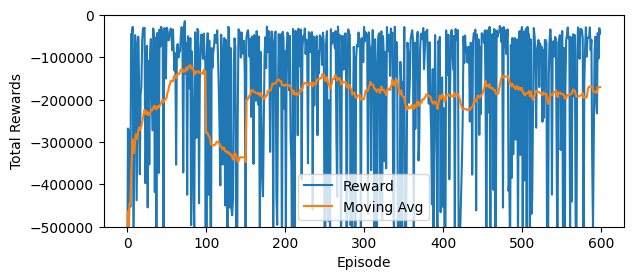

In [11]:
def running_avg(totalrewards):
    N = len(totalrewards)
    totalrewards = np.array(totalrewards)
    running_avg = np.empty(N)
    for t in range(N):
        running_avg[t] = totalrewards[max(0, t-50):(t+1)].mean()
    return running_avg
plt.figure(figsize=(6, 3))
plt.plot(score_history,label='Reward')
plt.plot(running_avg(score_history), label='Moving Avg')
plt.xlabel('Episode')
plt.ylabel('Total Rewards')
plt.legend()
plt.tight_layout()
plt.savefig("Pendulum_SAC_r.pdf", bbox_inches='tight')
plt.ylim(-500000, 0)
plt.show()

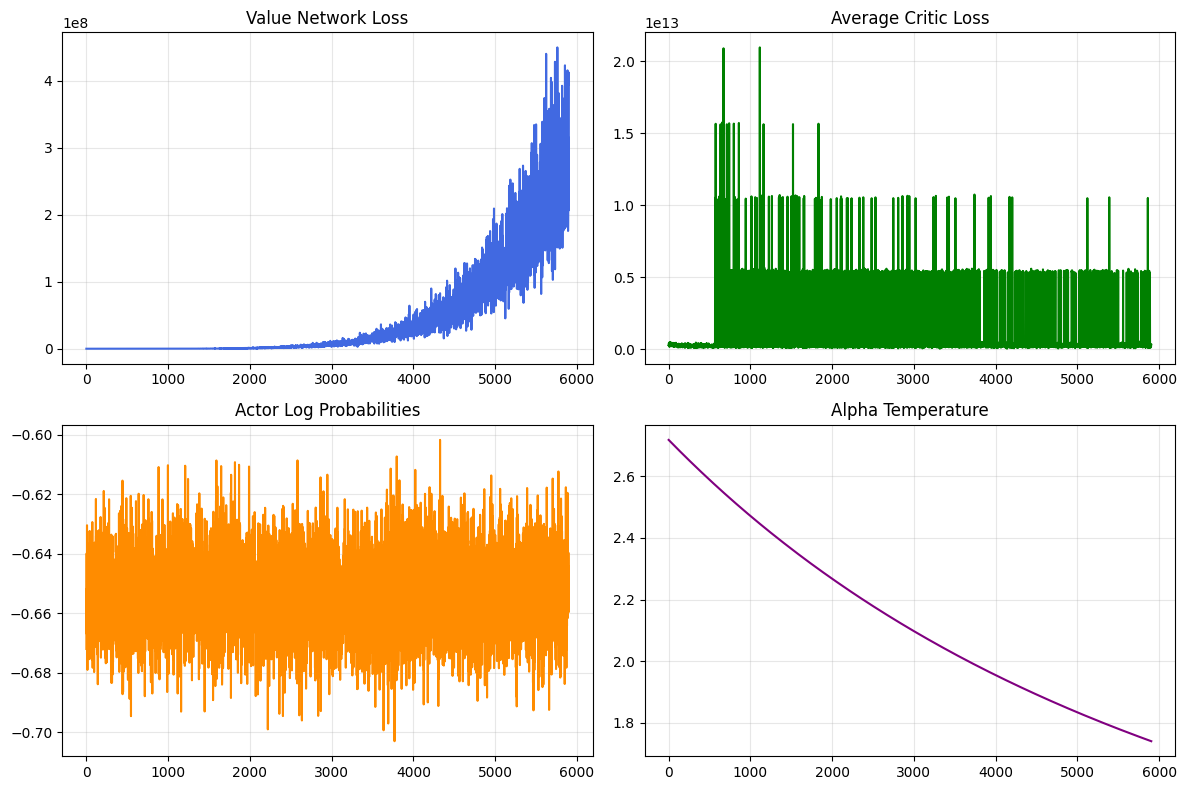

In [12]:
plt.figure(figsize=(12, 8))

# Value Loss
plt.subplot(2, 2, 1)
plt.plot(agent.value_loss_history, color='royalblue')
plt.title('Value Network Loss')
plt.grid(True, alpha=0.3)

# Critic Loss
plt.subplot(2, 2, 2)
plt.plot(agent.critic_loss_history, color='green')
plt.title('Average Critic Loss')
plt.grid(True, alpha=0.3)

# Actor Log Probs
plt.subplot(2, 2, 3)
plt.plot(agent.actor_probs_history, color='darkorange')
plt.title('Actor Log Probabilities')
plt.grid(True, alpha=0.3)

# Alpha
plt.subplot(2, 2, 4)
plt.plot([np.exp(a) for a in agent.alpha_history], color='purple')
plt.title('Alpha Temperature')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("training_metrics.pdf")
plt.show()

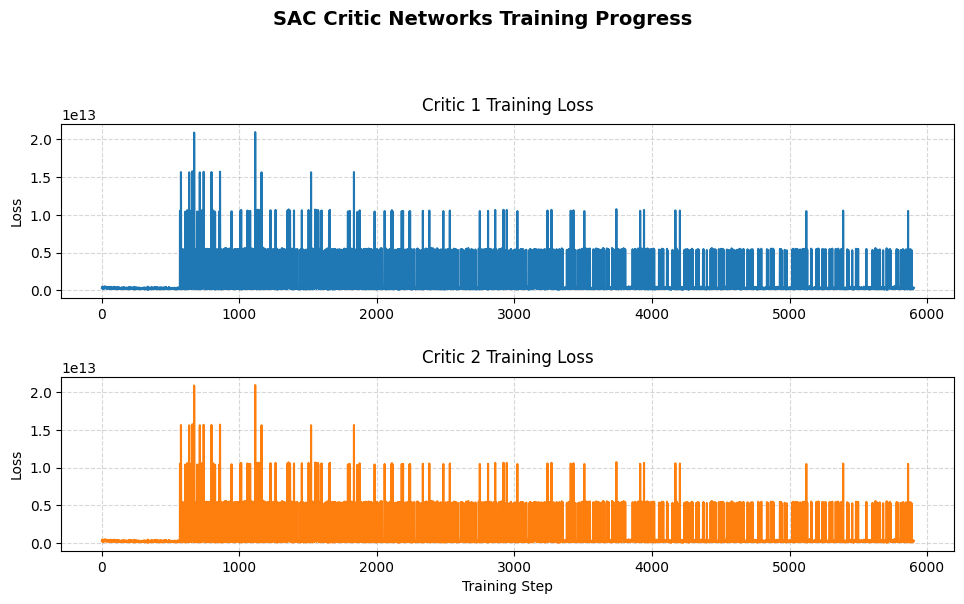

In [13]:
plt.figure(figsize=(10, 6))

# Common settings
plot_params = {
    'linewidth': 1.5,
    'alpha': 0.7,
    'grid': True,
    'grid_style': '--',
    'title_fontsize': 12,
    'label_fontsize': 10
}

# Critic 1 Loss plot
plt.subplot(2, 1, 1)
plt.plot(agent.critic_1_loss_history, 
         color='#1f77b4',
         label='Critic 1 Loss')
plt.title('Critic 1 Training Loss', fontsize=plot_params['title_fontsize'], pad=10)
plt.ylabel('Loss', fontsize=plot_params['label_fontsize'])
plt.grid(True, linestyle=plot_params['grid_style'], alpha=0.5)

# Critic 2 Loss plot
plt.subplot(2, 1, 2)
plt.plot(agent.critic_2_loss_history,
         color='#ff7f0e',
         label='Critic 2 Loss')
plt.title('Critic 2 Training Loss', fontsize=plot_params['title_fontsize'], pad=10)
plt.xlabel('Training Step', fontsize=plot_params['label_fontsize'])
plt.ylabel('Loss', fontsize=plot_params['label_fontsize'])
plt.grid(True, linestyle=plot_params['grid_style'], alpha=0.5)

plt.suptitle('SAC Critic Networks Training Progress', 
             y=1.02,
             fontsize=14,
             fontweight='bold')
plt.tight_layout(pad=2.0)
plt.savefig("SAC_Critic_Losses.pdf", bbox_inches='tight', dpi=300)
plt.show()


## State histogram

In [14]:
def suspension_simulation(agent, num_experiences=10, num_timesteps=200):
    state_history = []
    env = VehicleSuspensionEnv()  # Using your custom environment
    
    for _ in range(num_experiences):
        state = env.reset()  # Without receiving additional parameters
        for _ in range(num_timesteps):
            # Choose action with appropriate scaling
            action = agent.choose_action(state, deterministic=True)
            
            # Take a step in the environment
            next_state, reward, done, _ = env.step(action)
            
            # Store state history
            state_history.append({
                'timestep': _,
                'state': state.copy(),
                'action': action,
                'next_state': next_state.copy(),
                'reward': reward,
                'done': done
            })
            
            state = next_state
            if done:
                break
    
    return pd.DataFrame(state_history)  # Return a DataFrame for analysis

# Using the function
simulation_data = suspension_simulation(agent, num_experiences=10)


State history shape: (128, 8)


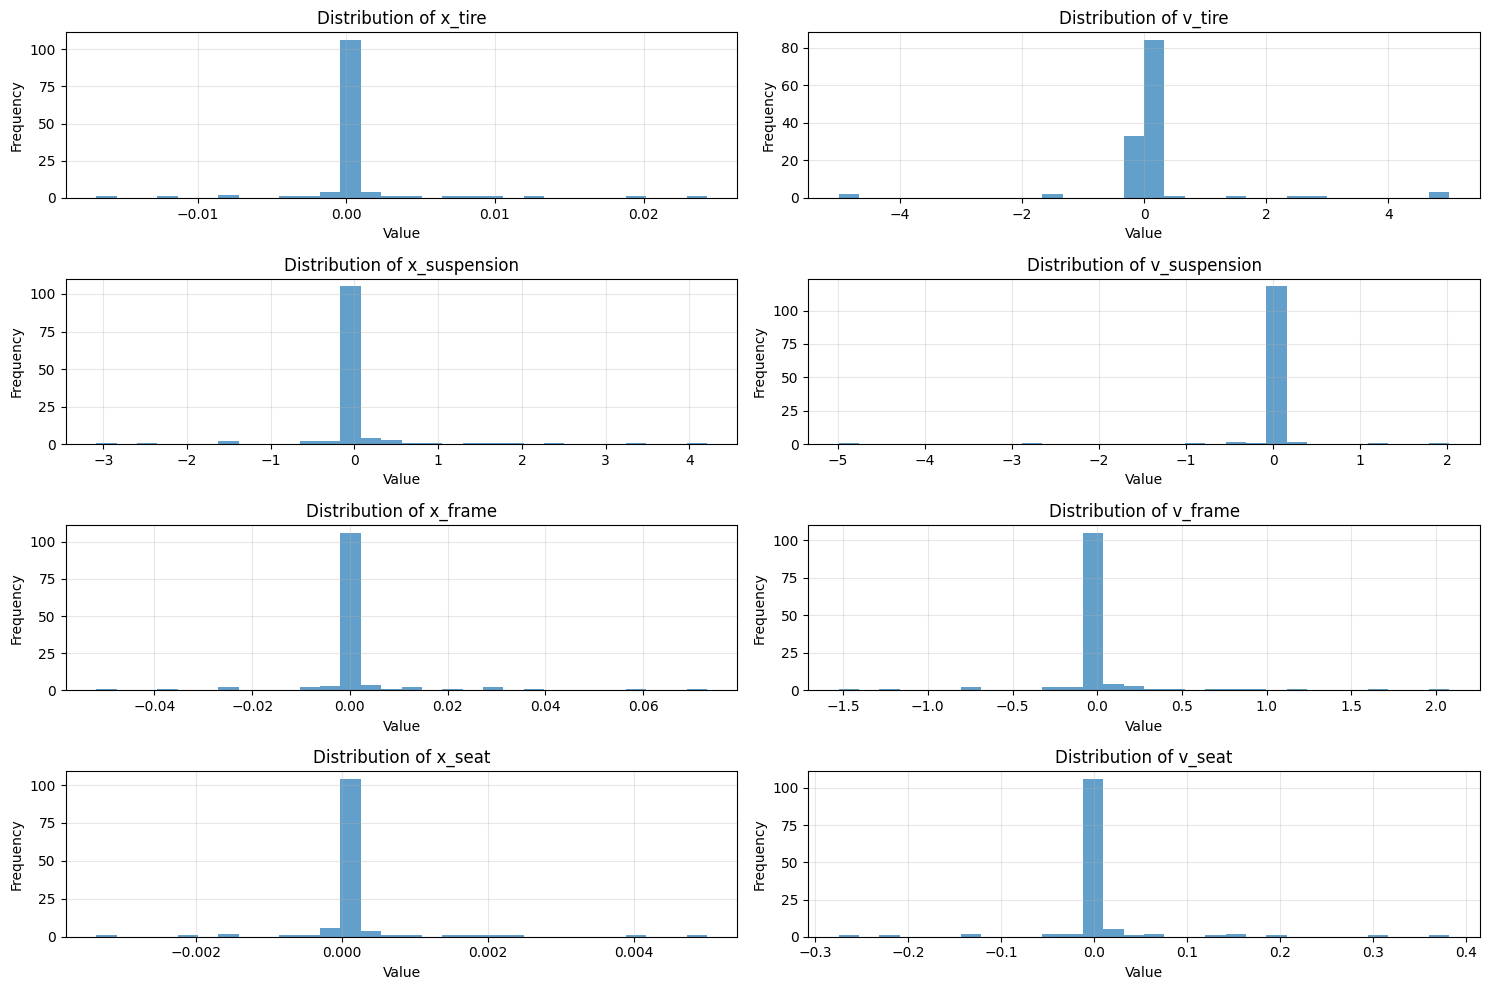

In [15]:
# Convert state history to numpy array with the correct shape
try:
    if isinstance(simulation_data, pd.DataFrame):
        state_history = np.stack(simulation_data['state'].values)
    else:
        state_history = np.stack([s['state'] for s in simulation_data])
except Exception as e:
    print(f"Error converting to array: {e}")
    print(f"First element: {simulation_data['state'].iloc[0] if isinstance(simulation_data, pd.DataFrame) else simulation_data[0]['state']}")

# Check the dimensions
print(f"State history shape: {state_history.shape}")

# If state_history is still one-dimensional:
if len(state_history.shape) == 1:
    state_history = np.array([x for x in state_history])

# Ensure correct shape
assert len(state_history.shape) == 2, f"Expected 2D array, got {state_history.shape}"

# Extract state variables
variables = {
    'x_tire': state_history[:, 0],
    'v_tire': state_history[:, 1],
    'x_suspension': state_history[:, 2],
    'v_suspension': state_history[:, 3],
    'x_frame': state_history[:, 4],
    'v_frame': state_history[:, 5],
    'x_seat': state_history[:, 6],
    'v_seat': state_history[:, 7]
}

# Create histograms
plt.figure(figsize=(15, 10))
for i, (name, values) in enumerate(variables.items(), 1):
    plt.subplot(4, 2, i)
    plt.hist(values, bins=30, alpha=0.7)
    plt.title(f'Distribution of {name}')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("suspension_state_distributions.pdf", bbox_inches='tight')
plt.show()
